In [3]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import xgboost as xgb
import joblib
import eli5
from eli5.sklearn import PermutationImportance
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import cross_val_score, HalvingGridSearchCV
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVC
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.patches as patches  # extra code – for the curved arrow
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score, recall_score
import lightgbm as lgb
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score, recall_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

warnings.filterwarnings('ignore')

In [4]:
%matplotlib inline

In [5]:
X_train, y_train, X_test, y_test = joblib.load('data_FAA/data.pkl')
redo_grid_search = 0
cm = 0

In [6]:
if redo_grid_search:
  PARAMETERS = {'n_estimators' : [30, 100, 200, 300, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950],
              'max_features': ["sqrt", "log2", None],
              "min_impurity_decrease": [0.0, 0.1, 0.5]
                }

  # HalvingGridSearchCV
  svc2_search = HalvingGridSearchCV(estimator=ExtraTreesClassifier(n_jobs=-1),param_grid=PARAMETERS,verbose = 1,
                                                            cv = 5,scoring='accuracy',max_resources=2000,random_state = 0,
                                                            resource='n_samples',n_jobs=-1).fit(X_train.values, y_train.values.ravel())

  et_best = svc2_search.best_estimator_
  print("ET")
  print('ET Best Score',svc2_search.best_score_)
  print('ET Best Parmas',svc2_search.best_params_)
  print('ET Accuracy',cross_val_score(et_best,X_train.values, y_train.values.ravel(), cv=5).mean())
else:
  print("ET Best Score 0.7860824742268042")
  et_best =  ExtraTreesClassifier(max_features="sqrt", n_estimators=750)

ET Best Score 0.7860824742268042


In [15]:
y_pred = cross_val_predict(et_best, X_train, y_train, cv=20)

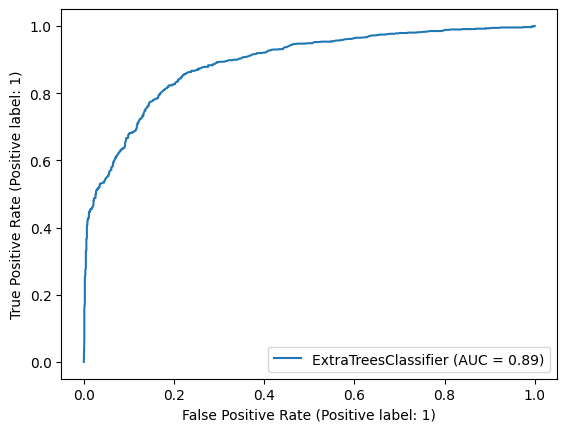

In [9]:
from sklearn.metrics import RocCurveDisplay
et_best.fit(X_train, y_train)
RocCurveDisplay.from_estimator(
   et_best, X_test, y_test)


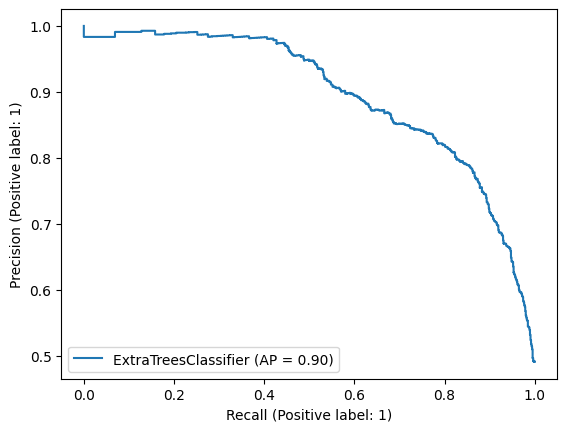

In [10]:
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_estimator(
   et_best, X_test, y_test)

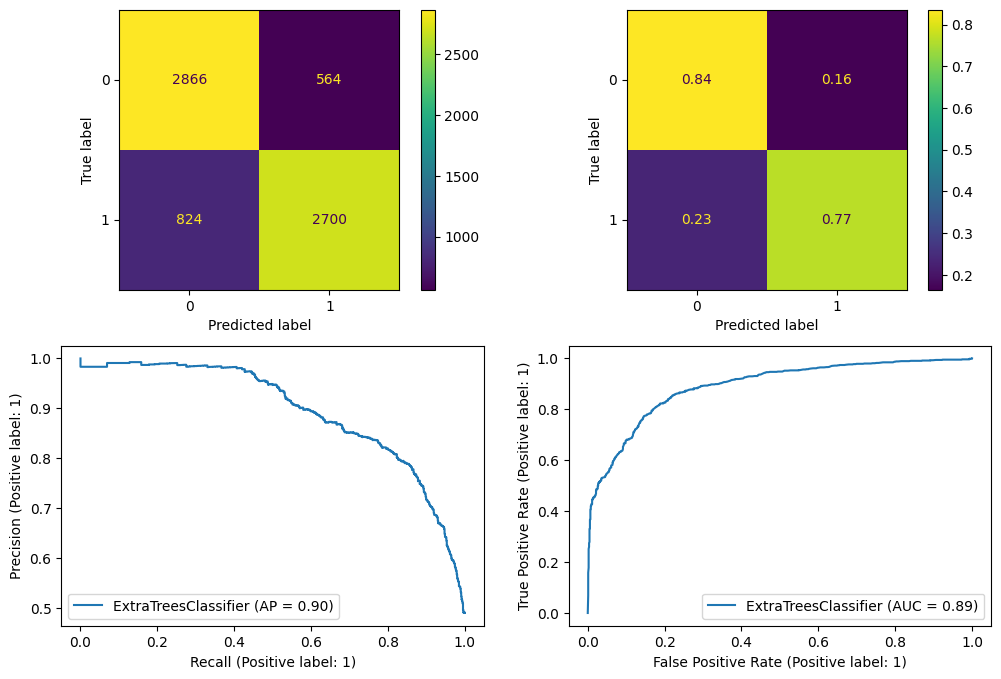

In [23]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(12, 8))
RocCurveDisplay.from_estimator(
   et_best, X_test, y_test, ax=ax[1, 1])


PrecisionRecallDisplay.from_estimator(
   et_best, X_test, y_test, ax=ax[1, 0])

ConfusionMatrixDisplay.from_predictions(y_train, y_pred, ax=ax[0, 0])
ConfusionMatrixDisplay.from_predictions(y_train, y_pred, normalize="true", ax=ax[0, 1])
plt.show()

In [24]:
%%time

# always use same RANDOM_STATE k-folds for comparability between tests, reproducibility
RANDOMSTATE = 42
np.random.seed(RANDOMSTATE)

kfolds = KFold(n_splits=20, shuffle=True, random_state=RANDOMSTATE)

MEAN_RESPONSE=y_train.mean()
def cv_to_raw(cv_val, mean_response=MEAN_RESPONSE):
    return np.expm1(mean_response+cv_val) - np.expm1(mean_response)
	
scores = -cross_val_score(et_best, X_train, y_train,
                          scoring="neg_root_mean_squared_error",
                          cv=kfolds,
                          n_jobs=-1)
raw_scores = [cv_to_raw(x) for x in scores]
print("Raw CV RMSE %.0f (STD %.0f)" % (np.mean(raw_scores), np.std(raw_scores)))

Raw CV RMSE 1 (STD 0)
CPU times: user 131 ms, sys: 191 ms, total: 322 ms
Wall time: 21.4 s


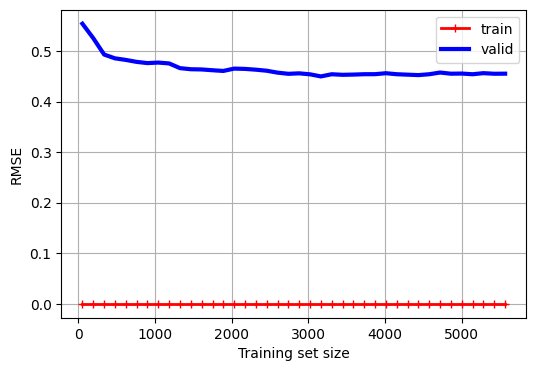

In [25]:
train_sizes, train_scores, valid_scores = learning_curve(
    et_best, X_train, y_train, train_sizes=np.linspace(0.01, 1.0, 40), cv=5,
    scoring="neg_root_mean_squared_error")
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.figure(figsize=(6, 4))  # extra code – not needed, just formatting
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")

# extra code – beautifies and saves Figure 4–15
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.legend(loc="upper right")
# plt.axis([0, 1000, 0.3, 0.9])
# plt.save_fig("underfitting_learning_curves_plot")

plt.show()

In [26]:
def pandas_preprocessing(X, y_present=True):
  X['PassengerId_split'] = X['PassengerId'].apply(lambda x : str(x).split(sep = '_', maxsplit=1))
  X['Group']= X['PassengerId_split'].apply(lambda x : np.nan if x[0] == 'nan' else x[0])
  X['Group_id']= X['PassengerId_split'].apply(lambda x : np.nan if x[0] == 'nan' else x[1])
  X = X.drop(['PassengerId','PassengerId_split'],axis=1)

  # Split the names
  X['Name_split'] = X['Name'].apply(lambda x : str(x).split(sep = ' ', maxsplit=1))
  X['Surname']= X['Name_split'].apply(lambda x : np.nan if x[0] == 'nan' else x[1])
  X = X.drop(['Name','Name_split'],axis=1)

  # Split the cabins
  X['Cabin_splt'] = X['Cabin'].apply(lambda x : str(x).split(sep = '/'))
  X['Deck']= X['Cabin_splt'].apply(lambda x : np.nan if x[0] == 'nan' else x[0])
  X['CabinNumber']= X['Cabin_splt'].apply(lambda x : np.nan if x[0] == 'nan' else x[1]).astype('float')
  X['CabinSide']= X['Cabin_splt'].apply(lambda x : np.nan if x[0] == 'nan' else x[2])
  X = X.drop(['Cabin','Cabin_splt'],axis=1)

  # Create Total
  numeric_cols = list(X.select_dtypes(include = np.number).columns)
  X['Total'] = sum(X[col] for col in numeric_cols if col not in ["Age", "CabinNumber"])
  X['age'] = pd.cut(x=X['Age'], bins=range(0, 90, 10))
  X['total'] = pd.cut(x=X['Total'], bins=[-35.987, 3598.7, 7197.4, 10796.1, 14394.8, 17993.5, 21592.2, 25190.9, 28789.6, 32388.3, 35987.])
  X = X.drop(['Age', "Total"],axis=1)
  X['age'] = X['age'].astype('str') 
  X['total'] = X['total'].astype('str')
  target = X['Transported']
  target = target.astype(int)
  X = X.drop(['Transported'],axis=1)
  return X, target

In [27]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import make_column_selector, make_column_transformer


warnings.filterwarnings('ignore')

In [49]:
bol_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    )

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
    )


num_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
    (bol_pipeline, make_column_selector(dtype_include=bool)),
)

In [60]:
#----------------For submission----------------
data1= pd.read_csv("data_FAA/train.csv")
data2 = pd.read_csv("data_FAA/evaluation.csv")
data2['Transported'] =-1

data1, y1 = pandas_preprocessing(data1)
data2, y2 = pandas_preprocessing(data2)

data1 = preprocessing.fit_transform(data1)
data2 = preprocessing.transform(data2)

et_best.fit(data1, y1)

pred = et_best.predict(data2)

pred = pred.astype(bool)
result=pd.read_csv('data_FAA/sample_submission_et.csv')
result['Transported'] = pred
result.to_csv('submission.csv', index=False)

FileNotFoundError: [Errno 2] No such file or directory: 'data_FAA/sample_submission_et.csv'